<a href="https://colab.research.google.com/github/Prab999/CSCI167/blob/main/project/project_167_nbahofA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports, dataset upload, set device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from google.colab import files

uploaded = files.upload()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Saving NBAHof_Final_Dataset.csv to NBAHof_Final_Dataset.csv
Using device: cpu


In [2]:
# Load dataset
df = pd.read_csv("NBAHof_Final_Dataset.csv")

# Separate features and target
target_col = "Is Hall of Famer"

#Dropping columns from test, Most added as ways to merge datasets
drop_cols = [
    "FULL_NAME",
    "FIRST_NAME",
    "LAST_NAME",
    "FULL_NAME_LOWER",
    "FIRST_NAME_LOWER",
    "LAST_NAME_LOWER",
    "full_name_lower",
    "name_key",
]

feature_df = df.drop(columns=drop_cols + [target_col])
print("Feature shape", feature_df.shape)

feature_df = feature_df.copy()
#Currently data set lists active players retirement year as a NAN, swapping this
#with the year 2030
feature_df["RETIREMENT_YEAR"] = feature_df["RETIREMENT_YEAR"].fillna(2030)
feature_df["RETIREMENT_YEAR"].isna().sum()

X = feature_df.values.astype("float32")
y = df[target_col].values.astype("float32")

print("X shape:", X.shape)
print("y shape:", y.shape)

Feature shape (3093, 38)
X shape: (3093, 38)
y shape: (3093,)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train/validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Wrap arrays in pytorch to use dataloader
#store x and y as tensors
class NBADataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        if hasattr(y, "values"):
            y = y.values
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
#create train and validation sets
train_dataset = NBADataset(X_train_scaled, y_train)
val_dataset   = NBADataset(X_val_scaled,   y_val)

#Dataloader for training
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False)


Using device: cpu


In [5]:
#Deep MLP model, fully connected
class DeepMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=None):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [128, 128, 64] #hiddden dimensions

        #building layers
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h

        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    #forward pass
    def forward(self, x):
        return self.net(x)

input_dim = X_train_scaled.shape[1]
deep_model = DeepMLP(input_dim).to(device)
deep_model


DeepMLP(
  (net): Sequential(
    (0): Linear(in_features=38, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [6]:
#Loss function and optimizer Using weight for class imbalance
pos_weight = torch.tensor([3.0])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(deep_model.parameters(), lr=0.001)
num_epochs = 20


In [7]:
#Training loop per epoch
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for xb, yb in dataloader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        running_correct += (preds == yb).sum().item()
        total += xb.size(0)

    return running_loss / total, running_correct / total

#Validation loop
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0
    all_logits = []
    all_labels = []

    for xb, yb in dataloader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)

        running_loss += loss.item() * xb.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        running_correct += (preds == yb).sum().item()
        total += xb.size(0)

        all_logits.append(logits.cpu())
        all_labels.append(yb.cpu())

    return (
        running_loss / total,
        running_correct / total,
        torch.cat(all_logits),
        torch.cat(all_labels),
    )


In [8]:
#Main loop storing history for graphs
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(deep_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_logits, val_labels = evaluate(deep_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 01 | Train Loss: 0.1961, Train Acc: 0.9842 | Val Loss: 0.1117, Val Acc: 0.9790
Epoch 02 | Train Loss: 0.0667, Train Acc: 0.9887 | Val Loss: 0.0868, Val Acc: 0.9822
Epoch 03 | Train Loss: 0.0544, Train Acc: 0.9895 | Val Loss: 0.0918, Val Acc: 0.9822
Epoch 04 | Train Loss: 0.0440, Train Acc: 0.9907 | Val Loss: 0.1271, Val Acc: 0.9871
Epoch 05 | Train Loss: 0.0410, Train Acc: 0.9915 | Val Loss: 0.1059, Val Acc: 0.9855
Epoch 06 | Train Loss: 0.0343, Train Acc: 0.9927 | Val Loss: 0.0785, Val Acc: 0.9838
Epoch 07 | Train Loss: 0.0349, Train Acc: 0.9915 | Val Loss: 0.0797, Val Acc: 0.9838
Epoch 08 | Train Loss: 0.0335, Train Acc: 0.9915 | Val Loss: 0.0818, Val Acc: 0.9677
Epoch 09 | Train Loss: 0.0236, Train Acc: 0.9919 | Val Loss: 0.1305, Val Acc: 0.9919
Epoch 10 | Train Loss: 0.0251, Train Acc: 0.9947 | Val Loss: 0.1181, Val Acc: 0.9887
Epoch 11 | Train Loss: 0.0200, Train Acc: 0.9939 | Val Loss: 0.1709, Val Acc: 0.9903
Epoch 12 | Train Loss: 0.0156, Train Acc: 0.9964 | Val Loss: 0.18

In [ ]:
#Statistics for better comparision of performance
with torch.no_grad():
    probs = torch.sigmoid(val_logits)
    preds = (probs >= 0.5).float()

total = len(val_labels)
true_pos = int((val_labels == 1).sum())
pred_pos = int((preds == 1).sum())
tp = int(((preds == 1) & (val_labels == 1)).sum())
tn = int(((preds == 0) & (val_labels == 0)).sum())

print("Total val samples:", total)
print("True HOF:", true_pos)
print("Predicted HOF:", pred_pos)
print("TP:", tp)
print("TN:", tn)


Total val samples: 619
True HOF: 11
Predicted HOF: 7
TP: 7
TN: 608


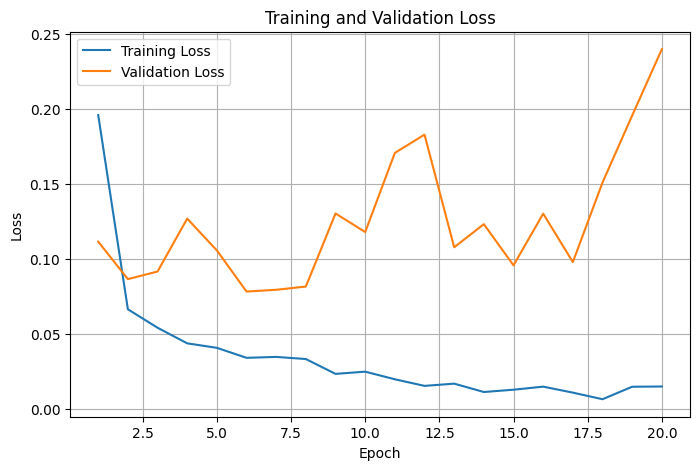

In [11]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

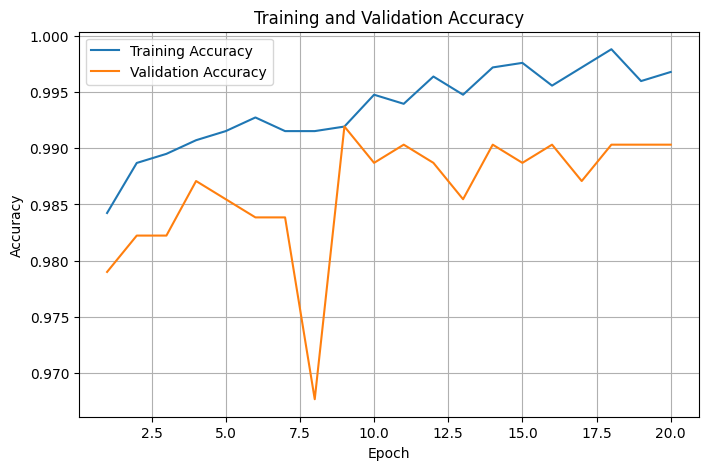

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accs, label='Training Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()